In [54]:
import pandas as pd
import torch
import importlib

#%load_ext line_profiler

In [55]:
from model.eGauss_plus import eGAUSSp

Client 1: {1: 12, 2: 11}
Client 2: {0: 25, 2: 14}
Client 3: {0: 11, 1: 18, 2: 14}
Test Set: {0: 14, 1: 20, 2: 11}

Combined Number of Samples per Class:
Class 0: 50 samples
Class 1: 50 samples
Class 2: 50 samples

Total Number of Samples Across All Datasets: 150


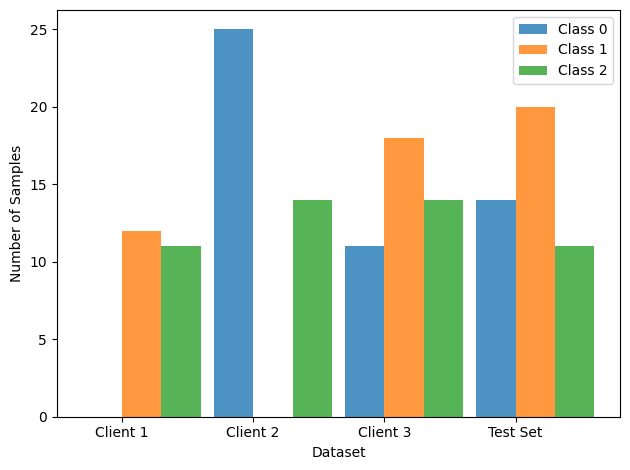

In [56]:
from utils.utils_dataset import prepare_non_iid_dataset, plot_dataset_split, display_dataset_split
from sklearn import datasets

# Load the Iris dataset
iris = datasets.load_iris()

X = iris.data
y = iris.target

num_clients = 3
train_data, test_data, all_data = prepare_non_iid_dataset(X, y, num_clients)

display_dataset_split(train_data, test_data)
plot_dataset_split(train_data, test_data)


In [57]:

# Model parameters
local_model_params = {
    "feature_dim": 4,
    "num_classes": 3,
    "N_max": 1,
    "num_sigma": 2,
    "kappa_join": 1.5,
    "S_0": 1e-10,
    "c_max": 4,
    "device": torch.device("cpu")
}
federated_model_params = {
    "feature_dim": 4,
    "num_classes": 3,
    "N_max": 1,
    "num_sigma": 2,
    "kappa_join": 2,
    "S_0": 1e-10,
    "c_max": 2,
    "device": torch.device("cpu")
}

# Initialize a model for each client
local_models = [eGAUSSp(**local_model_params) for _ in range(num_clients)]
federated_model = eGAUSSp(**federated_model_params)


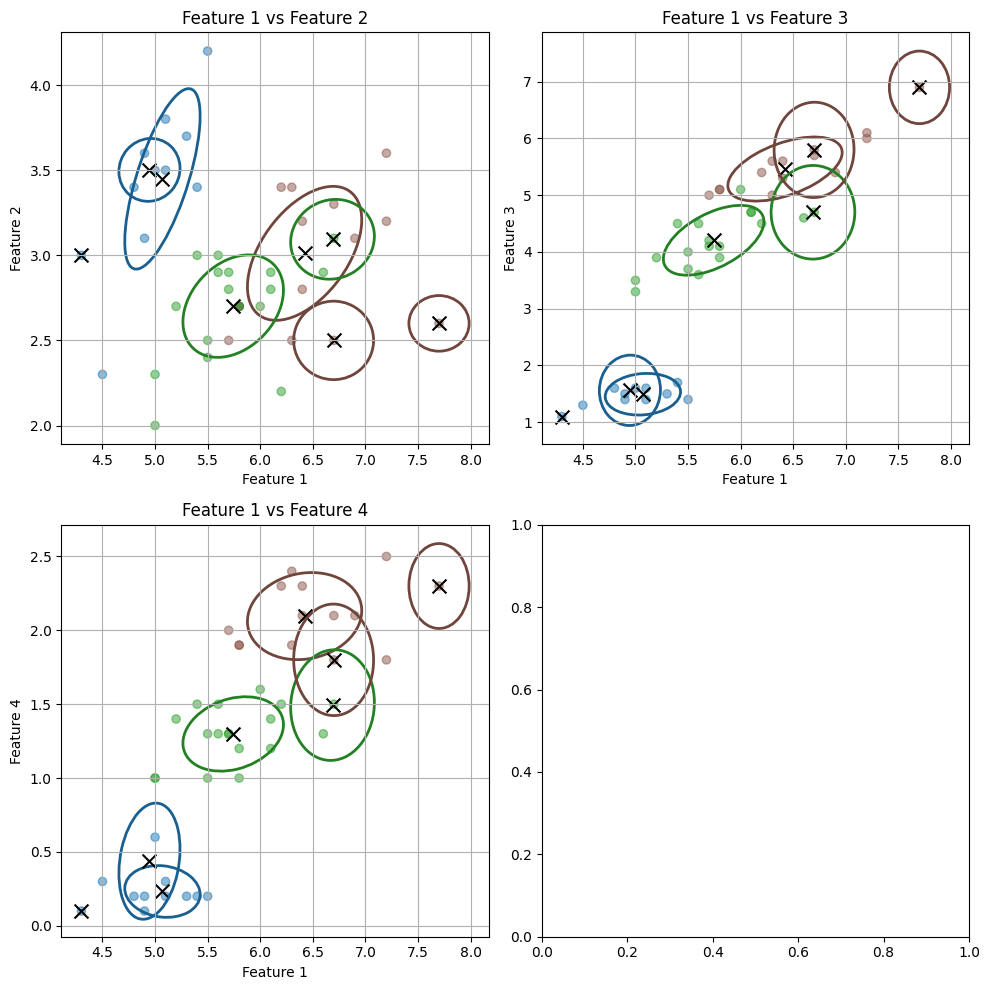

In [67]:
import utils.utils_train
importlib.reload(utils.utils_train)
from utils.utils_train import train_supervised, train_unsupervised
from utils.utils_plots import plot_first_feature

# Assuming models and client_data are already defined
for client_idx, client_model in enumerate(local_models):
    print(f"Training model for client {client_idx + 1}")
    train_supervised(client_model, train_data[client_idx]) 
    plot_first_feature(train_data[client_idx], model=client_model, num_sigma=2, N_max=1)  


In [68]:
from utils.utils_train import test_model   

# Testing each client's model on the global test dataset
for client_idx, client_model in enumerate(local_models):
    print(f"\nTesting model for client {client_idx + 1}")
    test_model(client_model, test_data)
    test_model(client_model, all_data)



Testing model for client 1


Evolving has been disabled.
Test Accuracy: 0.9333333333333333, Precision: 0.9388552188552188, Recall: 0.9333333333333333, F1 Score: 0.9295115182592497
Evolving has been disabled.
Test Accuracy: 0.96, Precision: 0.961060442771585, Recall: 0.96, F1 Score: 0.9596851068602005

Testing model for client 2
Evolving has been disabled.
Test Accuracy: 0.3111111111111111, Precision: 0.7856790123456789, Recall: 0.3111111111111111, F1 Score: 0.14764595103578154
Evolving has been disabled.
Test Accuracy: 0.3333333333333333, Precision: 0.7777777777777777, Recall: 0.3333333333333333, F1 Score: 0.16666666666666666

Testing model for client 3
Evolving has been disabled.
Test Accuracy: 0.9333333333333333, Precision: 0.9332275132275132, Recall: 0.9333333333333333, F1 Score: 0.932559039876113
Evolving has been disabled.
Test Accuracy: 0.9533333333333334, Precision: 0.9543690619563764, Recall: 0.9533333333333334, F1 Score: 0.9532912954992827


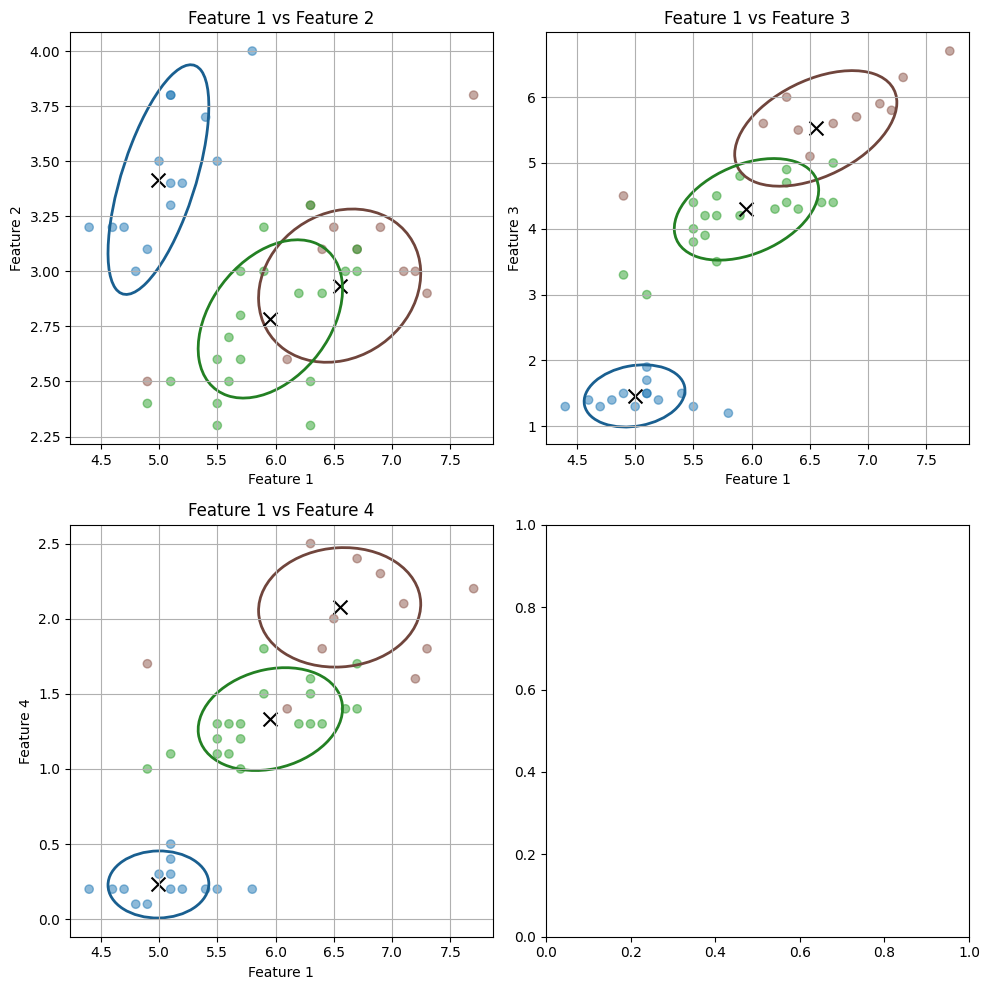

In [60]:
  
import utils.utils_train
importlib.reload(utils.utils_train)
from utils.utils_train import test_model


for client_idx, client_model in enumerate(local_models):
        print(f"Merging client {client_idx + 1}")
        federated_model.federal_agent.merge_model(client_model)

federated_model.federal_agent.federated_merging()

plot_first_feature(test_data, model=federated_model, num_sigma=2, N_max=0)   



In [62]:

print(f"\nTesting federated model")   

test_model(federated_model, test_data)
test_model(federated_model, all_data)


Testing federated model
Evolving has been disabled.
Test Accuracy: 0.3111111111111111, Precision: 0.7856790123456789, Recall: 0.3111111111111111, F1 Score: 0.14764595103578154
Evolving has been disabled.
Test Accuracy: 0.3333333333333333, Precision: 0.7777777777777777, Recall: 0.3333333333333333, F1 Score: 0.16666666666666666
